In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)
sns.set()

In [2]:
URL = 'http://vfacstaff.ltu.edu/lshamir/data/assym/p_all_full.csv'
df = pd.read_csv(URL)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 455 entries, rotation to ID
dtypes: float64(383), int64(71), object(1)
memory usage: 46.7+ MB


In [4]:
df.replace(-9999.00, np.nan, inplace=True)
df_dropped = df.dropna()
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12952 entries, 0 to 13439
Columns: 455 entries, rotation to ID
dtypes: float64(408), int64(46), object(1)
memory usage: 45.1+ MB


In [5]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_dropped.drop('rotation', axis=1), df_dropped['rotation'], 
                                                    random_state=42, stratify=df_dropped['rotation'])

In [7]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5176034589252625

In [8]:
cv_model = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid={'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}, cv=5)
cv_model.fit(X_train, y_train)
cv_model.best_params_

{'C': 0.001}

In [9]:
cv_model.score(X_test, y_test)

0.5176034589252625

In [10]:
cv_model.score(X_train, y_train)

0.5184270125591929

In [11]:
probs = cv_model.predict_proba(X_test)
probs = probs[:, 1]
no_skill = np.zeros(len(y_test))

In [12]:
tpr, fpr, thresh = roc_curve(y_test, probs, pos_label='cw')
ns_tpr, ns_fpr, ns_thresh = roc_curve(y_test, no_skill, pos_label='cw')

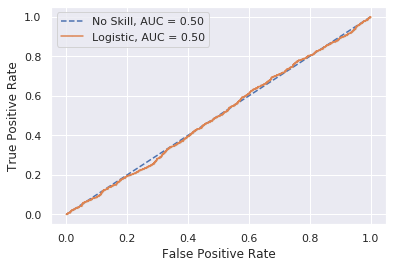

In [14]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill, AUC = %.2f' % auc(ns_fpr, ns_tpr))
plt.plot(fpr, tpr, marker='.', markersize=0.1, label='Logistic, AUC = %.2f' % auc(fpr, tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [17]:
from sklearn.feature_selection import RFE
feature_nums = [5, 10, 20, 30, 40, 50]
feature_results = []

for num in feature_nums:
    rfe_model = RFE(LogisticRegression(C=0.001, solver='lbfgs'), n_features_to_select=num).fit(X_train, y_train)
    feature_results.append((num, rfe_model.score(X_test, y_test)))

print(feature_results)

[(5, 0.5179122915379865), (10, 0.5169857936998147), (20, 0.5169857936998147), (30, 0.5169857936998147), (40, 0.5169857936998147), (50, 0.5169857936998147)]


In [18]:
rfe_model = RFE(LogisticRegression(C=0.001, solver='lbfgs'), n_features_to_select=5).fit(X_train, y_train)
rfe_model.ranking_

array([427,  32, 186, 343, 259,  62, 426, 440, 416, 439, 449, 260,   1,
        50, 356,  38, 347, 422, 390, 376, 399,  45,  52,  49,  55,  54,
       251, 353, 357, 318, 332,  42,  48,  37,  40,  43, 295, 367, 346,
       324, 385, 436, 438, 434, 430, 429, 435, 437, 431, 433, 432, 188,
       187, 193, 192, 189, 386, 322, 331, 309, 310, 185, 183, 180, 179,
       175, 392, 410, 378, 337, 352, 161, 159, 157, 150, 140, 202, 375,
       330, 326, 348, 194, 190, 320, 134, 118,  31, 125,  58, 151, 115,
       191, 164, 155, 141, 135, 109,  63, 102,  94, 124, 148, 162, 142,
       133, 130,  59, 108,  76,  61,  64, 300, 296, 293, 298, 297, 338,
       425, 369, 355, 395, 299, 292, 291, 288, 285, 342, 424, 373, 358,
       398, 272, 268, 266, 270, 262, 254, 252, 250, 249, 207, 112,  89,
       145, 119,  82, 116,  87, 147, 121,  83, 113,  88, 146, 120,  81,
        35,  29,  30,  33,  34,  97,  90, 153, 123,  84, 261, 255, 257,
       258, 265, 315, 319, 394, 374, 382, 340, 333, 325, 335, 30

In [30]:
sig_features = []
for i, feat_rank in enumerate(rfe_model.ranking_):
    if feat_rank == 1:
        sig_features.append(X_train.columns[i])
    else:
        continue
sig_features.append('rotation')
sig_features

['flags', 'flags_u', 'flags_g', 'flags_r', 'flags_i', 'rotation']

In [31]:
#sig_features = sig_features.append('rotation')
sig_df = df_dropped[sig_features]
X_train, X_test, y_train, y_test = train_test_split(sig_df.drop('rotation', axis=1), sig_df['rotation'], 
                                                   random_state=42, stratify=sig_df['rotation'])

In [32]:
#scales at least quadratically with num of samples; considering using svm.linearSVC instead
#from sklearn.svm import SVC
#svm_mod = SVC()